In [23]:
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_csv('../data/raw/fullpilot13_2.csv')

df = df[df.expName.isin(['FullPilot13'])]

df = df.groupby('prolificID').filter(lambda x: len(x) >= 480)
# df = df.groupby('prolificID').filter(lambda x: len(x) <= 432)
# keep  prolificIDs that are more than 10 characters
df = df[df.prolificID.str.len() > 10]
# show prolificIDs
len(df.prolificID.unique())

64

In [24]:
df['opti_ss'] = ((df.m1 > df.m2) & (df.choice==1)) | ((df.m1 < df.m2) & (df.choice==2))
df['opti_ff'] = ((df.p1 > df.p2) & (df.choice==1)) | ((df.p1 < df.p2) & (df.choice==2))
df['opti_ev'] = ((df.ev1 > df.ev2) & (df.choice==1)) | ((df.ev1 < df.ev2) & (df.choice==2))

<Axes: xlabel='t', ylabel='opti_ss'>

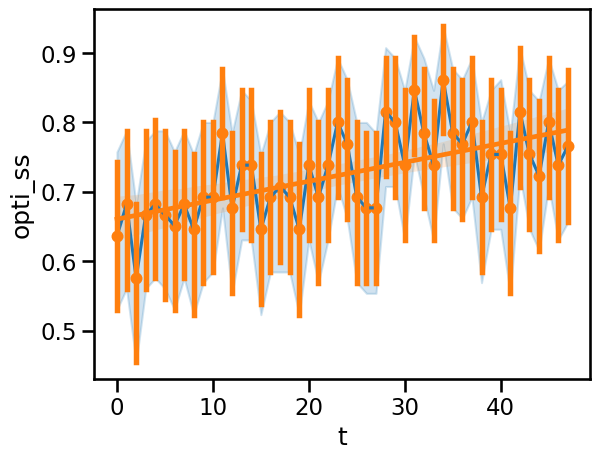

In [102]:
sns.lineplot(data=df[df.session==2], x='t', y='opti_ss')
sns.regplot(data=df[df.session==2], x='t', y='opti_ss', x_estimator=np.mean, order=1)



PearsonRResult(statistic=0.5176290089909337, pvalue=1.1857541467158112e-05)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                opti_ff   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     22.69
Date:                Fri, 15 Nov 2024   Prob (F-statistic):           1.19e-05
Time:                        18:40:30   Log-Likelihood:                 44.509
No. Observations:                  64   AIC:                            -85.02
Df Residuals:                      62   BIC:                            -80.70
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3728      0.057      6.582      0.000       0.260       0.486
opti_ff        0.3765      0.079      4.764      0.000       0.219       0.534
==============================================================================
Omnibus:                        2.799   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.247   Jarque-Bera (JB):                2.727
Skew:                           0.461   Prob(JB):                        0.256
Kurtosis:                       2.586   Cond. No.                         7.67
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

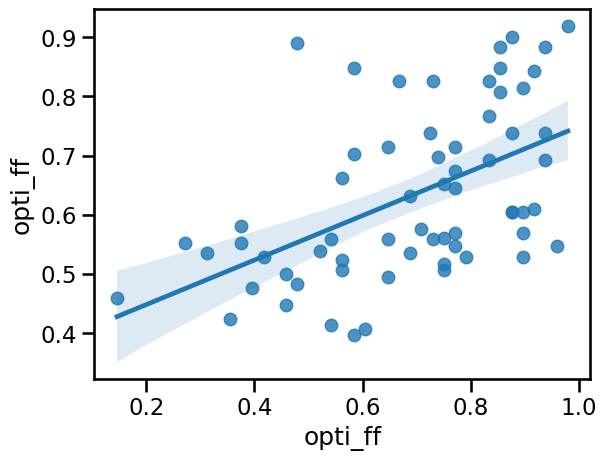

In [109]:
# correlation between opti_ss in session 2 and 3
means_ss1 = df[df.session==1].groupby('prolificID').opti_ff.mean()
means_ss2 = df[df.session==3].groupby('prolificID').opti_ff.mean()

import scipy.stats as stats

print(stats.pearsonr(means_ss1, means_ss2))
sns.set_context('talk')
sns.regplot(x=means_ss1, y=means_ss2)

import statsmodels.api as sm

X = sm.add_constant(means_ss1)
model = sm.OLS(means_ss2, X)
results = model.fit()
results.summary()

t
0     0.636364
1     0.681818
2     0.575758
3     0.666667
4     0.681818
5     0.666667
6     0.651515
7     0.681818
8     0.646154
9     0.692308
10    0.692308
11    0.784615
12    0.676923
13    0.738462
14    0.738462
15    0.646154
16    0.692308
17    0.707692
18    0.692308
19    0.646154
20    0.738462
21    0.692308
22    0.738462
23    0.800000
24    0.769231
25    0.692308
26    0.676923
27    0.676923
28    0.815385
29    0.800000
30    0.738462
31    0.846154
32    0.784615
33    0.738462
34    0.861538
35    0.784615
36    0.769231
37    0.800000
38    0.692308
39    0.753846
40    0.753846
41    0.676923
42    0.815385
43    0.753846
44    0.723077
45    0.800000
46    0.738462
47    0.765625
Name: opti_ss, dtype: float64

In [30]:
from scipy import odr

x = df[df.session==2].t.unique()
y = df[df.session==2].groupby('t').opti_ss.mean()

data = odr.Data(x, y)

odr_obj = odr.ODR(data, odr.exponential)

output = odr_obj.run()

print(output.beta)

[-0.3371916   0.00253506]


<Axes: >

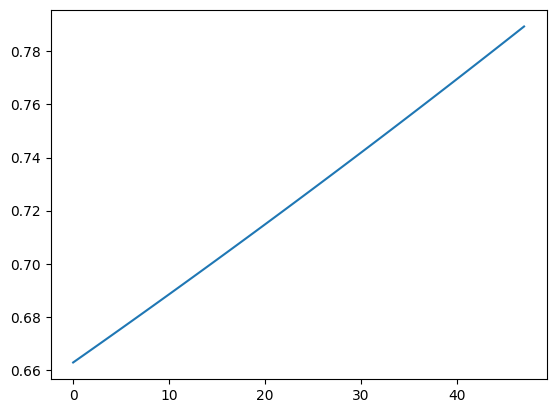

In [32]:
from scipy import odr
import seaborn as sns
import numpy as np


y = output.beta[0] + np.exp(output.beta[1]*x)

sns.lineplot(x=x, y=y)
# [-10.    0.5]

In [82]:
# fit a linear regression model to each participant in each session
import scipy as sp

# df.columns

df_sess_1_fit = df[df.session==2].groupby('prolificID').apply(lambda x: sp.stats.linregress(x['t'], x['opti_ss']))

df_sess_1_fit = pd.DataFrame(df_sess_1_fit.tolist(), columns=['slope', 'intercept', 'r_value', 'p_value', 'std_err'], index=df_sess_1_fit.index)


# plot opt_ss and slope of each participant side by side

import seaborn as sns
import matplotlib.pyplot as plt

df_sess_1_fit['opti_ss'] = df[df.session==2].groupby('prolificID')['opti_ss'].mean()

                                                                                                                                                        
new_df = pd.DataFrame(
     {      
            'variable': ['slope']*len(df_sess_1_fit) + ['opti_ss']*len(df_sess_1_fit),
            'value': list(df_sess_1_fit['slope'].values.flatten()) + list(df_sess_1_fit['opti_ss'].values.flatten()),
     }
)

import statsmodels.api as sm

X = new_df[new_df.variable=='slope']['value'].values
y = new_df[new_df.variable=='opti_ss']['value'].values

X = sm.add_constant(X)

sm.OLS(y, X).fit().summary()

# sns.barplot(x='variable', y='value', data=new_df)

C:\Users\garciaba\AppData\Local\Temp\ipykernel_22492\39466376.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sess_1_fit = df[df.session==2].groupby('prolificID').apply(lambda x: sp.stats.linregress(x['t'], x['opti_ss']))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.8239
Date:                Fri, 15 Nov 2024   Prob (F-statistic):              0.368
Time:                        18:14:37   Log-Likelihood:                 10.233
No. Observations:                  61   AIC:                            -16.47
Df Residuals:                      59   BIC:                            -12.24
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7601      0.030     24.990      0.000       0.699       0.821
x1             4.5589      5.023      0.908      0.368      -5.491      14.609
==============================================================================
Omnibus:                       12.928   Durbin-Watson:                   1.773
Prob(Omnibus):                  0.002   Jarque-Bera (JB):                7.447
Skew:                          -0.684   Prob(JB):                       0.0242
Kurtosis:                       1.971   Cond. No.                         189.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

# Set random seed for reproducibility
np.random.seed(42)

# 1. Data Simulation
def generate_data(num_samples=100, true_mu=500, true_sigma=50):
    """Simulate reaction times with a normal distribution."""
    reaction_times = np.random.normal(loc=true_mu, scale=true_sigma, size=num_samples)
    # Ensure reaction times are positive
    reaction_times = reaction_times[reaction_times > 0]
    return reaction_times

# 2. Define Bayesian Models
def gaussian_model(reaction_times):
    with pm.Model() as model:
        # Priors for Gaussian parameters
        mu = pm.Normal('mu', mu=400, sigma=200)
        sigma = pm.HalfNormal('sigma', sigma=100)
        
        # Likelihood
        likelihood = pm.Normal('obs', mu=mu, sigma=sigma, observed=reaction_times)
    return model

def exponential_model(reaction_times):
    with pm.Model() as model:
        # Priors for Exponential parameters
        decay = pm.HalfNormal('decay', sigma=1)
        scale = pm.HalfNormal('scale', sigma=100)
        
        # Define the Exponential model as a custom likelihood
        # Assuming the reaction times follow an Exponential distribution shifted by 'scale'
        # Alternatively, you can model it differently based on theoretical considerations
        likelihood = pm.Exponential('obs', lam=decay, observed=reaction_times)
    return model

# 3. Fit Models Using Bayesian Inference
def fit_model(model, model_name, draws=2000, tune=1000):
    print(f"Fitting {model_name} model...")
    with model:
        trace = pm.sample(draws=draws, tune=tune, return_inferencedata=True, target_accept=0.95)
    print(f"{model_name} model fitted.\n")
    return trace

# 4. Model Comparison Using WAIC
def compare_models(traces, model_names):
    # Compute WAIC for each model
    waics = [az.waic(trace, scale='deviance') for trace in traces]
    
    # Create a DataFrame for comparison
    comparison = pd.DataFrame({
        'Model': model_names,
        'WAIC': [waic.waic for waic in waics],
        'WAIC_SE': [waic.waic_se for waic in waics]
    })
    
    # Sort by WAIC
    comparison = comparison.sort_values('WAIC')
    comparison['Delta_WAIC'] = comparison['WAIC'] - comparison['WAIC'].min()
    
    print("Model Comparison (Lower WAIC is Better):")
    print(comparison)
    return waics, comparison

# 5. Visualization
def plot_results(reaction_times, traces, model_names):
    x = np.linspace(min(reaction_times), max(reaction_times), 1000)
    
    plt.figure(figsize=(10, 6))
    
    # Histogram of the data
    plt.hist(reaction_times, bins=30, density=True, alpha=0.5, label='Data')
    
    # Plot posterior predictive means
    for trace, name in zip(traces, model_names):
        if name == 'Gaussian':
            mu = trace.posterior['mu'].mean().item()
            sigma = trace.posterior['sigma'].mean().item()
            y = az.stats.norm.pdf(x, mu, sigma)
            plt.plot(x, y, label=f'{name} Model')
        elif name == 'Exponential':
            lam = trace.posterior['obs'].mean().item()  # Using 'lam' parameter from Exponential
            y = lam * np.exp(-lam * x)
            plt.plot(x, y, label=f'{name} Model')
    
    plt.xlabel('Reaction Time')
    plt.ylabel('Density')
    plt.title('Temporal Expectation Models')
    plt.legend()
    plt.show()

# Main Execution
if __name__ == "__main__":
    # Generate example data
    reaction_times = generate_data(num_samples=200, true_mu=500, true_sigma=50)
    
    # Define models
    model_gaussian = gaussian_model(reaction_times)
    model_exponential = exponential_model(reaction_times)
    
    # Fit models
    trace_gaussian = fit_model(model_gaussian, 'Gaussian')
    trace_exponential = fit_model(model_exponential, 'Exponential')
    
    # Compare models
    traces = [trace_gaussian, trace_exponential]
    model_names = ['Gaussian', 'Exponential']
    waics, comparison = compare_models(traces, model_names)
    
    # Print model diagnostics
    for trace, name in zip(traces, model_names):
        print(f"Summary for {name} model:")
        print(az.summary(trace, var_names=['mu', 'sigma']) if name == 'Gaussian' else az.summary(trace, var_names=['decay', 'scale']))
        print("\n")
    
    # Plot results
    plot_results(reaction_times, traces, model_names)


ModuleNotFoundError: No module named 'pymc'

In [9]:
# remove duplicate rows (if any)

# df = df.drop_duplicates(subset=['prolificID', 'session', 't'], keep='first')
# drop rows where choice is 0
df = df[df.choice != 0]